## Global Open Science Electrophysiology

### 9. Causality and mediation tools for q-EEG and clinical applications

Tutorials created by Qing Wang (Vincent), all related materials regarding this tutorial are in this [GitHub Repo](https://github.com/Vincent-wq/causal_course_eeg).

In [1]:
# import libs used in this example
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import graphviz

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

print("dowhy version = ", dowhy.__version__)

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dowhy version =  0.11.1


### Example set up using qEEG as mediator for treatment effect of neuroEPO

Notice: This is a **simulation example** for tutorial purpose only using the clinical settings from the Maria's paper entitled [The Effect of Neuroepo on Cognition in Parkinson’s Disease Patients Is Mediated by Electroencephalogram Source Activity](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2022.841428/full).

#### The mediation model in the original paper is as follows:

![image](https://www.frontiersin.org/files/Articles/841428/fnins-16-841428-HTML-r1/image_m/fnins-16-841428-g001.jpg)




/tmp/ipykernel_190547/441380794.py:91: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="twopi")


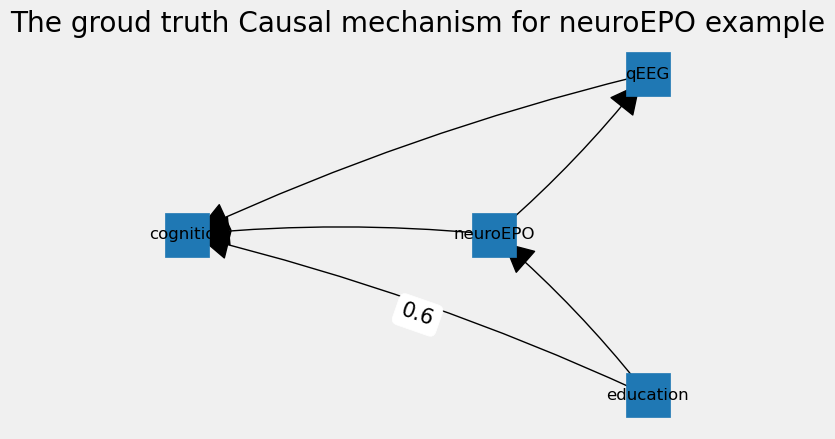

In [217]:
# First, we'll build the ground truth causal structure, i.e. structrual causal model (SCM)

class neuroEPO_SCM:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=4)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            treatment_ = np.array([treatment_value]*sample_size)
        else:
            treatment_ = u_z + 0.7*u

        # Creating the Golden standard model   
        confounding_effect = 0.25*u_x  
        mediator_effect = 0.6*treatment_ + 0.25*u_z
        overall_effect  = mediator_effect  + 0.25*u + confounding_effect + 0.9*treatment_
        
        return treatment_, mediator_effect, overall_effect, confounding_effect
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

# Create the graph describing the causal structure
gt_graph = """
graph [
    directed 1
    
    node [
        id "Z" 
        label "neuroEPO"
    ]  
    node [
        id "X" 
        label "education"
    ]   
    node [
        id "M"
        label "qEEG"
    ]
    node [
        id "Y"
        label "cognition"
    ]
    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "X"
        target "Y"
        weight  0.6
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "Z"
        target "M"
    ]

    edge [
        source "M"
        target "Y"
    ]

]
"""

import networkx as nx
from io import StringIO
# Read the GML graph
from networkx.drawing.nx_pydot import graphviz_layout

gml_file_like = StringIO(gt_graph)
G = nx.parse_gml(gml_file_like)
#pos = nx.circular_layout(G)
pos = graphviz_layout(G, prog="twopi")
# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_shape='s', node_size=1000)
# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), arrowstyle='-|>', 
                       arrowsize=50, connectionstyle ="arc3,rad=0.05")
# Draw the node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
# Draw the edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)
plt.title("The groud truth Causal mechanism for neuroEPO example")
plt.axis('off') 
plt.show()


In [218]:
# Instantiate the SCM
scm = neuroEPO_SCM(random_seed = 0)

# Generate observational data
neuro_EPO_obv, qEEG_obv, cognition_obv, confounding_obv= scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([neuro_EPO_obv, qEEG_obv, cognition_obv, confounding_obv]).T, columns=['Z', 'M', 'Y', 'X'])
df

,Z,M,Y,X
0,1.808156,0.634256,4.019257,0.468122
1,8.814906,6.443447,16.604006,0.728254
2,0.052192,-0.538027,1.069428,0.728496
3,-0.335992,-0.725667,0.900625,1.300006
4,4.366864,3.491521,8.585848,0.849415
...,...,...,...,...
995,2.680090,1.777754,4.931042,0.026461
996,2.377171,0.671855,5.058973,0.320891
997,3.147625,1.441004,7.745991,1.708587
998,-0.245924,-0.463053,0.686394,1.007897


In [227]:
# Create the graph describing the causal structure
neuroEPO_graph = """
graph [
    directed 1
    
    node [
        id "Z" 
        label "Z"
    ]  
    node [
        id "X" 
        label "X"
    ]   
    node [
        id "M"
        label "M"
    ]
    node [
        id "Y"
        label "Y"
    ]
    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "X"
        target "Y"
        weight  0.5
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "Z"
        target "M"
    ]

    edge [
        source "M"
        target "Y"
    ]

]
"""

#    edge [
#        source "X"
#        target "Z"
#    ]
#    edge [
#        source "X"
#        target "Y"
#    ]

#    edge [
#        source "Z"
#        target "Y"
#    ]


The graphical model specified:


/tmp/ipykernel_190547/3702462531.py:16: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="twopi")


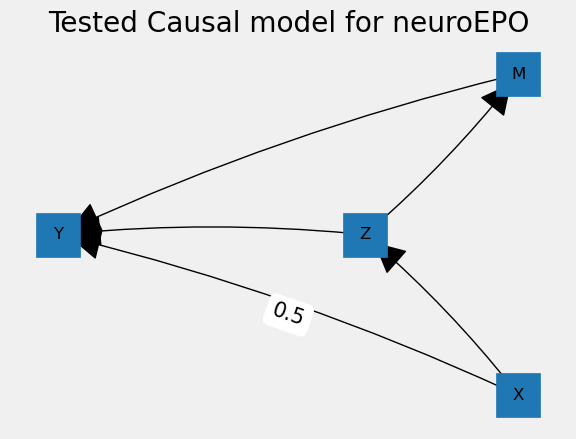

In [228]:
# define the model
model = CausalModel(
    data=df,
    treatment='neuroEPO',
    outcome='Cognition',
    common_causes = 'Education',
    graph=neuroEPO_graph
)
print("The graphical model specified:")


gml_file_like = StringIO(neuroEPO_graph)
G = nx.parse_gml(gml_file_like)
#pos = nx.circular_layout(G)
pos = graphviz_layout(G, prog="twopi")
# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_shape='s', node_size=1000)
# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), arrowstyle='-|>', 
                       arrowsize=50, connectionstyle ="arc3,rad=0.05")
# Draw the node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
# Draw the edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)
plt.title("Tested Causal model for neuroEPO")
plt.axis('off') 
plt.show()


In [229]:
# estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|X])
d[Z]        
Estimand assumption 1, Unconfoundedness: If U→{Z} and U→Y then P(Y|Z,X,U) = P(Y|Z,X)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [231]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): 1.7954248813036935


/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [232]:
refute_subset = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.4)

/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [233]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:1.7954248813036935
New effect:1.7948937391105744
p value:0.84



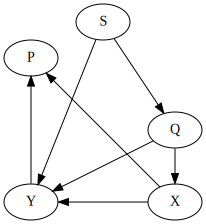

In [12]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['S', 'Q', 'X', 'Y', 'P']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!', '1.7,0.9!']

edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_07_full_example')

graph

In [13]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

In [14]:
# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [15]:
print(gml_string)

graph [directed 1
	node [id "S" label "S"]
	node [id "Q" label "Q"]
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "P" label "P"]
	edge [source "S" target "Q"]
	edge [source "S" target "Y"]
	edge [source "Q" target "X"]
	edge [source "Q" target "Y"]
	edge [source "X" target "P"]
	edge [source "Y" target "P"]
	edge [source "X" target "Y"]
]


In [16]:
# Instantiate the CausalModel 
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
)

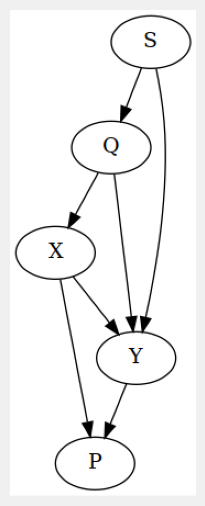

In [17]:
model.view_model()

In [18]:
# Get the estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False),
        },
        'fit_params': {}}
)

print(f'Estimate of causal effect (DML): {estimate.value}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Estimate of causal effect (DML): 0.6528130665938017


In [20]:
estimate_lr = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (linear regression): {estimate_lr.value}')

Estimate of causal effect (linear regression): 0.6858784883704395


In [21]:
random_cause = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause'
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [22]:
print(random_cause)

Refute: Add a random common cause
Estimated effect:0.6528130665938017
New effect:0.6737806276459242
p value:0.30000000000000004



In [23]:
placebo_refuter = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [24]:
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:0.6528130665938017
New effect:0.0
p value:1.0



In [25]:
import networkx as nx
from dowhy import gcm

In [26]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

In [27]:
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

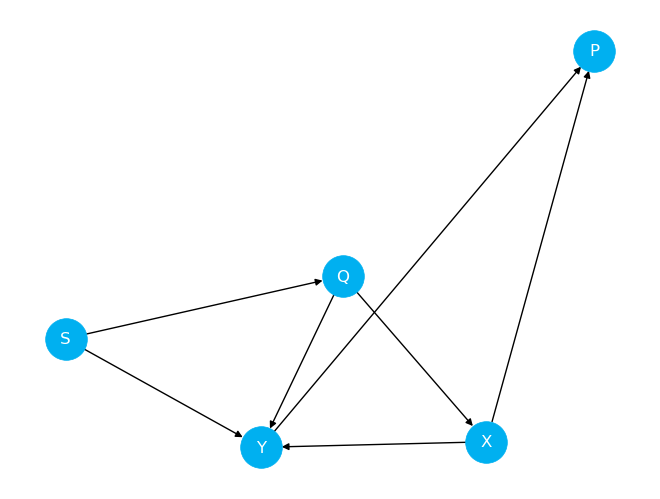

In [28]:
nx.draw(
    graph_nx, 
    with_labels=True, 
    node_size=900,
    font_color='white', 
    node_color=COLORS[0]
)

In [29]:
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

In [30]:
causal_model.set_causal_mechanism('S', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('X', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('P', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Q', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node P: 100%|██████████| 5/5 [00:00<00:00, 279.58it/s]


In [31]:
gcm.arrow_strength(causal_model, 'Y')

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


{('Q', 'Y'): 0.00036360429013388616,
 ('S', 'Y'): 0.008827871935490644,
 ('X', 'Y'): 0.006554104658159134}

In [32]:
gcm.counterfactual_samples(
    causal_model,
    {'X': lambda x: .21},
    observed_data=pd.DataFrame(data=dict(X=[.5], Y=[.75], S=[.5], Q=[.4], P=[.34])))

AttributeError: 'Index' object has no attribute '_format_flat'

     S    Q     X         Y         P
0  0.5  0.4  0.21  0.549555  0.177153